In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.rcParams["figure.figsize"] = [20,10]

### Helpers

In [3]:
# TODO try another kind of normalization, unit-normal etc.
# Normalization for DF with Credit/Debit => 0..1
def normalize(df, by="ID"):
    dfN = df.copy()
    titles = ["Debit", "Credit"]
    groups = dfN.groupby(by)
    sums = groups[titles].transform(np.sum)
    for column in titles:
        dfN[column] = dfN[column]/sums[column]
    dfN["from"] = dfN["Credit"] > 0.0
    return dfN
# Graph construction with networkX
def construct_graph(df):
        B = nx.DiGraph()
        B.add_nodes_from(df['ID'], bipartite=0)
        B.add_nodes_from(df['Name'], bipartite=1)
        B.add_weighted_edges_from(
            [(row['Name'], row['ID'], row["Credit"]) if row["from"]==True 
             else (row['ID'], row['Name'], row["Debit"]) 
             for idx, row in df.iterrows()], 
            weight='weight')
        return B
#     Graph plotting with bipartite layout
def plot_network(B, edges_label=True, title=None):
    colors = {0: "Blue", 1: "Red"}
    left = {n for n, d in B.nodes(data=True) if d['bipartite']==1}
    pos = nx.bipartite_layout(B, left)
    arc_weight=nx.get_edge_attributes(B,'weight')
    node_col = ["Red" if d['bipartite']==0 else "Blue" for n, d in B.nodes(data=True)]
    nx.draw(B, pos, node_color= node_col, with_labels=False, node_size=250)
    nx.draw_networkx_edges(B, pos, arrowsize=30)
    if edges_label:
        nx.draw_networkx_edge_labels(B, pos, node_size=250, edge_labels=arc_weight, font_size=16)
#     TODO add relative align for labels
    label_pos = pos.copy()
    for p in label_pos:  # raise text positions
        label_pos[p][1] += 0.05
    nx.draw_networkx_labels(B, pos, font_size=16)
    if title is not None and isinstance(title, str):
        plt.tight_layout()
        plt.savefig("img/"+title, dpi=140, pad_inches=0.01)
    plt.show()

### Vanila RandomWalk: Simply follow the direction, equal transition probability

In [156]:
from scipy.special import softmax
mask = {"IN": "OUT", "OUT": "IN"}
indexes = ["IN", "OUT"]
def def_step(G, vertex, direction="IN", use_weight=False, mode=1, debug=False):
    ws = list()
    tmp_vertex = None
    tmp_weight = None
    #         Making one step from BP node to Financial account node with transition probability ~ weights of edges.
    if direction=="IN":
        ins = G.in_edges(vertex, data=True)
    elif direction=="OUT":
        ins = G.out_edges(vertex, data=True)
    else:
        print("Wrong direction argument! IN or OUT are allowed!")
    if len(ins) > 0:
        if use_weight:
            ws = [edge[-1]["weight"] for edge in ins]
            p_ws = ws / np.sum(ws)
            ins = [edge[indexes.index(direction)] for edge in ins]
            tmp_idx = np.random.choice(range(len(ins)), p=p_ws)
            tmp_vertex = ins[tmp_idx]
            tmp_weight = ws[tmp_idx]
        else:
            ins = [edge[indexes.index(direction)] for edge in ins]
            tmp_vertex = np.random.choice(ins)
        if debug:
            print(tmp_vertex)
    else:
        return -1
    #             Making the 2nd step from FA to BP node (actual sampling)
    if direction=="IN":
        outs = G.in_edges(tmp_vertex, data=True)
    elif direction=="OUT":
        outs = G.out_edges(tmp_vertex, data=True)
    if len(outs) > 0:
        if use_weight:
            ws = [edge[-1]["weight"] for edge in outs]
            outs = [edge[indexes.index(direction)] for edge in outs]
            rm_idx = outs.index(vertex)
            ws.pop(rm_idx)
            outs.pop(rm_idx)
            if len(outs)==0:
                return -3
            ws = np.array(ws)
            if mode == 2:
#                 TODO Define that transormation in mathematical terms!!
                ws = softmax((1.0 - abs(ws - tmp_weight))*pressure)
            elif mode==1:
                ws = ws/np.sum(ws)
        else:
            outs = [edge[indexes.index(direction)] for edge in outs]
            if debug:
                print(outs)
            return np.random.choice(outs)
        if debug:
            print(list(zip(outs, ws)))
        return np.random.choice(outs, p=ws)
    else:
        return -2

### Directed meta-Path: from BP to BP

In [212]:
from scipy.special import softmax
mask = {"IN": "OUT", "OUT": "IN"}
indexes = ["IN", "OUT"]
def new_step(G, vertex, direction="IN", mode=2, allow_back=False, pressure=20, debug=False):
    ws = list()
    tmp_vertex = None
    tmp_weight = None
    #         Making one step from BP node to Financial account node with transition probability ~ weights of edges.
    if direction=="IN":
        ins = G.in_edges(vertex, data=True)
    elif direction=="OUT":
        ins = G.out_edges(vertex, data=True)
    else:
        print("Wrong direction argument! IN or OUT are allowed!")
    if len(ins) > 0:
        ws = [edge[-1]["weight"] for edge in ins]
        p_ws = ws / np.sum(ws)
        ins = [edge[indexes.index(direction)] for edge in ins]
        if mode==0:
                tmp_idx = np.random.choice(range(len(ins)))
        else:
            tmp_idx = np.random.choice(range(len(ins)), p=p_ws)
        tmp_vertex = ins[tmp_idx]
        tmp_weight = ws[tmp_idx]
        if debug:
            print(tmp_vertex)
    else:
        return -1
    #             Making the 2nd step from FA to BP node (actual sampling)
    if mask[direction]=="IN":
        outs = G.in_edges(tmp_vertex, data=True)
    elif mask[direction]=="OUT":
        outs = G.out_edges(tmp_vertex, data=True)
    if len(outs) > 0:
        ws = [edge[-1]["weight"] for edge in outs]
        outs = [edge[indexes.index(mask[direction])] for edge in outs]
        if not allow_back:
            rm_idx = outs.index(vertex)
            ws.pop(rm_idx)
            outs.pop(rm_idx)
        if len(outs)==0:
            return -3
        ws = np.array(ws)
        if mode == 2:
            ws = softmax((1.0 - abs(ws - tmp_weight))*pressure)
        if mode==1:
            ws = ws/np.sum(ws)
        elif mode==0:
            if debug:
                print(outs)
            return np.random.choice(outs)
        if debug:
            print(list(zip(outs, ws)))
        return np.random.choice(outs, p=ws)
    else:
        return -2

### Sampling: RandomWalk

In [183]:
# Default sampling with RandomWalk: follow the direction, uniform transition probability etc.
def def_randomWalk(G, vertex=None, lenght=3, direction="IN", use_weight=False, mode=1, debug=False):
    attempts = 10
    context = list()
    if vertex is None:
        context.append(random.choice(list(G.nodes)))
    else:
        context.append(vertex)
    cur_v = context[-1]
    while len(context)<lenght+1 and attempts>0:
        try:
            new_v = def_step(G, cur_v, direction, use_weight, mode, debug=debug)
            attempts-=1
        except nx.NetworkXError:
            break
        context.append(new_v)
        cur_v = new_v
    return context
# New Modified sampling: change the direction according to schema, chose the similar amounts of monetary flow
def new_randomWalk(G, vertex=None, lenght=3, direction="IN", repeat=True, pressure=20, mode=2, debug=False):
    attempts = 10
    context = list()
    if vertex is None:
        context.append(random.choice(list(G.nodes)))
    else:
        context.append(vertex)
    cur_v = context[-1]
    while len(context)<lenght+1 and attempts>0:
        try:
            new_v = new_step(G, cur_v, direction, mode=mode, debug=debug, pressure=pressure)
            attempts-=1
        except nx.NetworkXError:
            break
        context.append(new_v)
        cur_v = new_v
    return context

In [180]:
def make_pairs(sampled_seq, window=3, debug=False):
    if debug:
        print(sampled_seq)
    output = list()
    for cur_idx in range(len(sampled_seq)):
        for drift in range(max(0, cur_idx-window), min(cur_idx+window+1, len(sampled_seq))):
            if drift != cur_idx:
                output.append((sampled_seq[cur_idx], sampled_seq[drift]))
    return output

## Experiment 1. Hierarchical

In [4]:
# Construct test case with Sale BPs with different tax rates
def generate_sales_df(N=2, taxes=[0.06, 0.15, 0.25]):
    if taxes is not None:
        tax_rates = taxes
    if N is not None:
        N = N
    cur_id = 0
    data = pd.DataFrame(columns=["ID", "Name", "Journal", "Date", "Debit", "Credit"])
    for tax in tax_rates:
        for _ in range(N):
            #generate amounts
            rev = random.randint(10,1000)
            t = rev*tax+random.randint(2, 10)
            tr = rev+t
            data = data.append([pd.Series([cur_id, "Revenue", "Sales ledger", "01/01/2017", 0.0, rev], index=data.columns), 
                        pd.Series([cur_id, "Tax", "Sales ledger", "01/01/2017", 0.0, t], index=data.columns), 
                        pd.Series([cur_id, "Trade Receivables", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns)]
                        , ignore_index=True)
            cur_id+=1
    return data

In [5]:
generated_data = normalize(generate_sales_df())
exp1 = construct_graph(generated_data)

In [6]:
generated_data.head(6)

,ID,Name,Journal,Date,Debit,Credit,from
0,0,Revenue,Sales ledger,01/01/2017,0.0,0.940816,True
1,0,Tax,Sales ledger,01/01/2017,0.0,0.059184,True
2,0,Trade Receivables,Sales ledger,01/01/2017,1.0,0.000000,False
3,1,Revenue,Sales ledger,01/01/2017,0.0,0.935878,True
4,1,Tax,Sales ledger,01/01/2017,0.0,0.064122,True
5,1,Trade Receivables,Sales ledger,01/01/2017,1.0,0.000000,False


/Users/lex/anaconda3/envs/DL/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


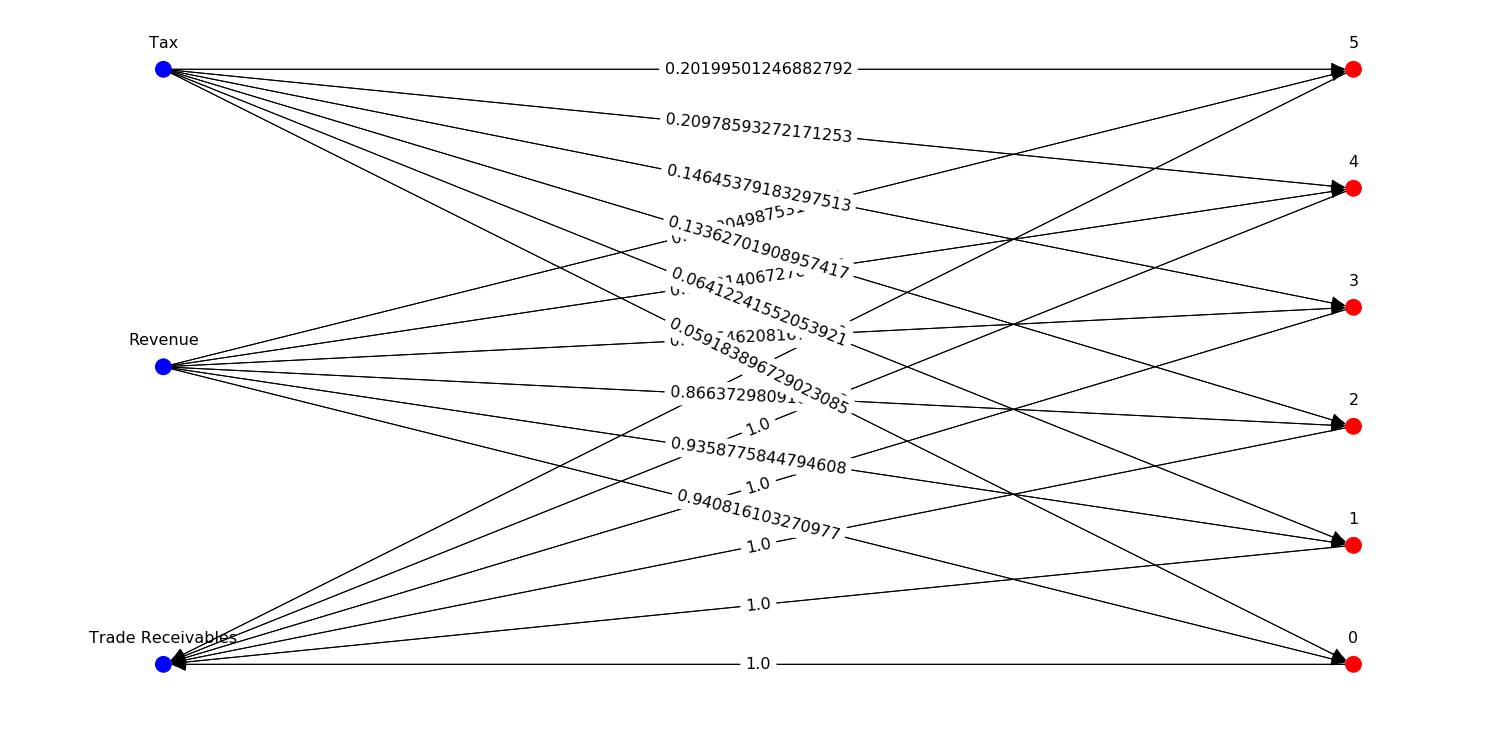

In [7]:
plot_network(exp1, title="Exp1")

In [15]:
new_randomWalk(exp1, 0, 10, direction="IN", repeat=False)

[0, 1, 0, 1, 0, 2, 0, 2, 1, 0, 4]

In [19]:
def_randomWalk(exp1, 0, 10, "IN")

[0, -2]

In [ ]:
# -------
from collections import Counter
cnt = Counter([step(exp1, 5, mode=2, direction="OUT") for _ in range(10)])
print(cnt)

In [223]:
import seaborn as sns
from collections import Counter
def plot_heatmap(pairs, title="HeatMap", size=6, norm="col", return_hm=False, absolute_vals = False, debug=False):
    cnt = dict(Counter(pairs))
    heatmap_data = np.zeros((size,size))
    if debug:
        print(cnt)
    for key, item in cnt.items():
        heatmap_data[key] = item
    if norm=="row":
        if not absolute_vals:
            heatmap_data = preprocessing.normalize(heatmap_data, axis=1, norm="l1")
        sns.heatmap(heatmap_data, annot=True, cmap="Blues")
    elif norm=="col":
        if not absolute_vals:
            heatmap_data = preprocessing.normalize(heatmap_data, axis=0, norm="l1")
        mask = np.zeros_like(heatmap_data)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(heatmap_data, mask=mask, annot=True, cmap="Blues")
    if title is not None and isinstance(title, str):
        plt.tight_layout()
        plt.savefig("img/"+title, dpi=140, pad_inches=0.01)
    plt.show()
    if return_hm:
        return heatmap_data
    

In [ ]:
pairs = [make_pairs(randomWalk(exp1, node, 10, direction="IN", repeat=False, pressure=11, mode=2)) for _ in range(10) for node in range(6)]
pairs = [item for sublist in pairs for item in sublist]
plot_heatmap(pairs, norm="col")

### Experiment 2. Noisy BP

In [85]:
# Construct test case with Sale BPs with noise financial accounts (with very small monetary flow)
def generate_noisy_df(N=2, noise_ratio=0.1):
    if N is not None:
        N = N
    cur_id = 0
    data = pd.DataFrame(columns=["ID", "Name", "Journal", "Date", "Debit", "Credit"])
    for it in range(N):
            rev = random.randint(10,1000)
            if it//(N-3)==0:
#             if random.random()>noise_ratio:
                #generate amounts
                t = rev*0.1
                tr = rev+t
                data = data.append([pd.Series([cur_id, "Revenue", "Sales ledger", "01/01/2017", 0.0, rev], index=data.columns), 
                        pd.Series([cur_id, "Tax", "Sales ledger", "01/01/2017", 0.0, t], index=data.columns), 
                        pd.Series([cur_id, "Trade Receivables", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns)]
                        , ignore_index=True)
            else:
                #generate amounts
                t = rev*0.08
                noise = rev*0.02
                right_noise1 = random.randint(5,int(rev)/20)
                right_noise2 = random.randint(5,int(rev)/20)
                tr = rev+t+noise-right_noise1-right_noise2
                data = data.append([pd.Series([cur_id, "Revenue", "Sales ledger", "01/01/2017", 0.0, rev], index=data.columns), 
                            pd.Series([cur_id, "Tax", "Sales ledger", "01/01/2017", 0.0, t], index=data.columns), 
                            pd.Series([cur_id, "W", "Sales ledger", "01/01/2017", 0.0, noise], index=data.columns), 
                            pd.Series([cur_id, "Z", "Sales ledger", "01/01/2017", right_noise1, 0.0], index=data.columns),
                            pd.Series([cur_id, "X", "Sales ledger", "01/01/2017", right_noise2, 0.0], index=data.columns),
                            pd.Series([cur_id, "Trade Receivables", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns)]
                            , ignore_index=True)
            cur_id+=1
    return data

In [86]:
generated_data = normalize(generate_noisy_df(10))
exp2 = construct_graph(generated_data)
generated_data.tail(10)

,ID,Name,Journal,Date,Debit,Credit,from
29,8,W,Sales ledger,01/01/2017,0.000000,0.018182,True
30,8,Z,Sales ledger,01/01/2017,0.035567,0.000000,False
31,8,X,Sales ledger,01/01/2017,0.017072,0.000000,False
32,8,Trade Receivables,Sales ledger,01/01/2017,0.947361,0.000000,False
33,9,Revenue,Sales ledger,01/01/2017,0.000000,0.909091,True
34,9,Tax,Sales ledger,01/01/2017,0.000000,0.072727,True
35,9,W,Sales ledger,01/01/2017,0.000000,0.018182,True
36,9,Z,Sales ledger,01/01/2017,0.023310,0.000000,False
37,9,X,Sales ledger,01/01/2017,0.041553,0.000000,False
38,9,Trade Receivables,Sales ledger,01/01/2017,0.935137,0.000000,False


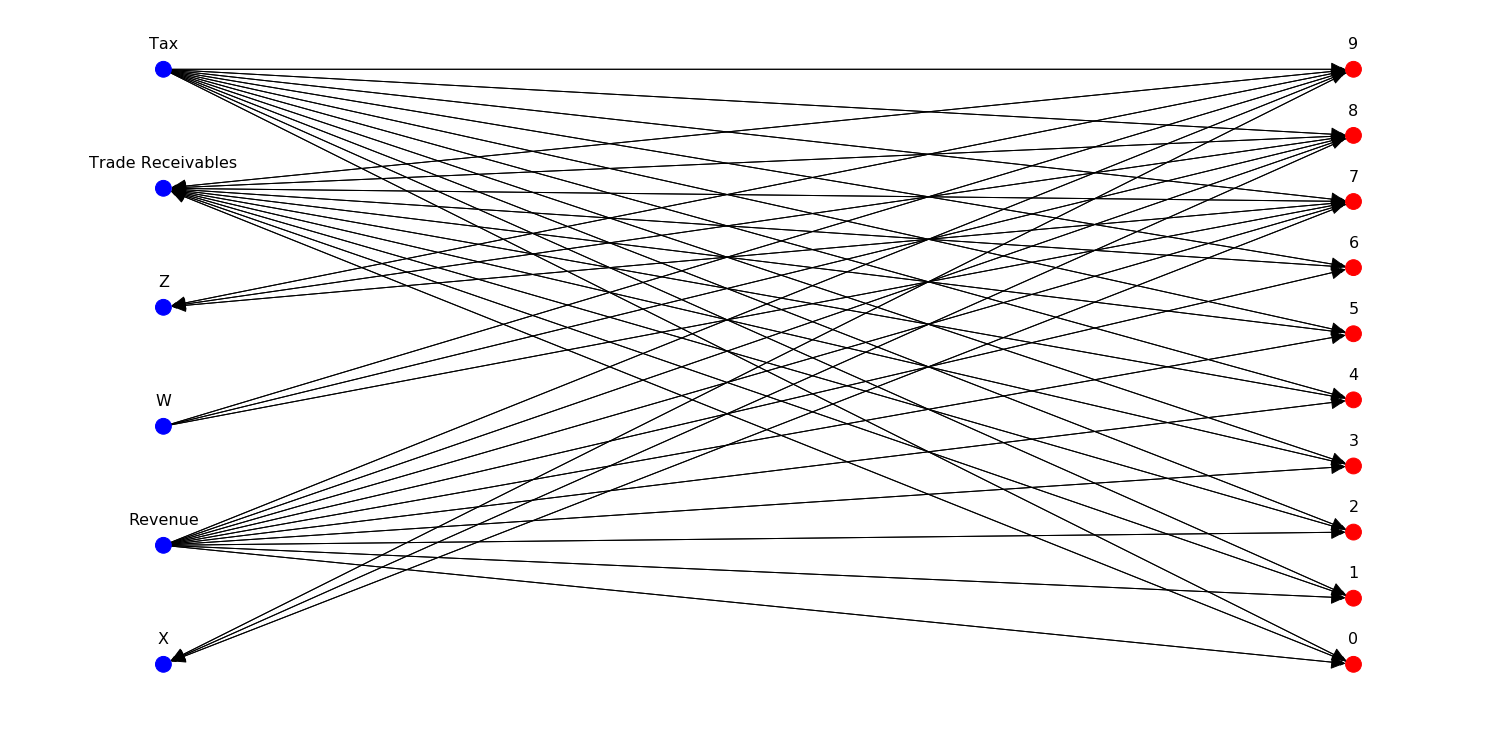

In [87]:
plot_network(exp2, title="Exp2", edges_label=False)

In [ ]:
pairs2 = [make_pairs(randomWalk(exp2, node, 10, direction="IN", repeat=False, pressure=11)) for _ in range(100) for node in range(10)]
pairs2 = [item for sublist in pairs2 for item in sublist]
plot_heatmap(pairs2, "HeatExp2", 10, "col")

### Experiment 3. Transition

In [ ]:
from scipy.special import softmax
mask = {"IN": "OUT", "OUT": "IN"}
indexes = ["IN", "OUT"]
def step_v2(G, vertex, direction="IN", p=0.2, allow_back=False, pressure=20, debug=False):
    ws = list()
    tmp_vertex = None
    tmp_weight = None
    #         Making one step from BP node to Financial account node with transition probability ~ weights of edges.
    if direction=="IN":
        ins = G.in_edges(vertex, data=True)
    elif direction=="OUT":
        ins = G.out_edges(vertex, data=True)
    else:
        print("Wrong direction argument! IN or OUT are allowed!")
    if len(ins) > 0:
        ws = [edge[-1]["weight"] for edge in ins]
        p_ws = ws / np.sum(ws)
        ins = [edge[indexes.index(direction)] for edge in ins]
        tmp_idx = np.random.choice(range(len(ins)), p=p_ws)
        tmp_vertex = ins[tmp_idx]
        tmp_weight = ws[tmp_idx]
        if debug:
            print(tmp_vertex)
    else:
        return -1
    #             Making the 2nd step from FA to BP node (actual sampling)
#     Chose the direction of next sub-step:
    if random.random()>p:
        new_direction = mask[direction]
    else:
        if debug:
            print("Continue deeper")
        new_direction = direction
    if debug:
        print(new_direction)
#         Actual step
    if new_direction=="IN":
        outs = G.in_edges(tmp_vertex, data=True)
    elif new_direction=="OUT":
        outs = G.out_edges(tmp_vertex, data=True)
    if len(outs) > 0:
        ws = [edge[-1]["weight"] for edge in outs]
        outs = [edge[indexes.index(new_direction)] for edge in outs]
        if not allow_back and direction!=new_direction:
            rm_idx = outs.index(vertex)
            ws.pop(rm_idx)
            outs.pop(rm_idx)
        if len(outs)==0:
            return -3
        ws = np.array(ws)
        ws = softmax((1.0 - abs(ws - tmp_weight))*pressure)
        if debug:
            print(list(zip(outs, ws)))
        return np.random.choice(outs, p=ws)
    else:
        return -2

In [ ]:
def randomWalk_v2(G, vertex=None, lenght=3, direction="IN", p=0.2, repeat=True, pressure=20, debug=False):
    attempts = 10
    context = list()
    if vertex is None:
        context.append(random.choice(list(G.nodes)))
    else:
        context.append(vertex)
    cur_v = context[-1]
    while len(context)<lenght+1 and attempts>0:
        try:
            new_v = step_v2(G, cur_v, direction, p=p, debug=debug, pressure=pressure)
            attempts-=1
        except nx.NetworkXError:
            break
        context.append(new_v)
        cur_v = new_v
    return context

In [ ]:
# Construct test case with Sale BPs with sequential chain of BPs: A->B->C etc.
def generate_transition_df(N=2):
    if N is not None:
        N = N
    cur_id = 0
    data = pd.DataFrame(columns=["ID", "Name", "Journal", "Date", "Debit", "Credit"])
    for it in range(N):
            rev = random.randint(10,1000)
            #generate amounts
            t = rev*0.20
            tr = rev+t
            data = data.append([pd.Series([cur_id, "A", "Sales ledger", "01/01/2017", 0.0, rev], index=data.columns), 
                        pd.Series([cur_id, "B", "Sales ledger", "01/01/2017", 0.0, t], index=data.columns), 
                        pd.Series([cur_id, "C", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns)]
                        , ignore_index=True)
            cur_id+=1
#             2nd BP
            rev = random.randint(10,1000)
            #generate amounts
            t = rev*0.20
            tr = rev+t
            data = data.append([pd.Series([cur_id, "C", "Sales ledger", "01/01/2017", 0.0, rev], index=data.columns), 
                        pd.Series([cur_id, "D", "Sales ledger", "01/01/2017", 0.0, t], index=data.columns), 
                        pd.Series([cur_id, "E", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns)]
                        , ignore_index=True)
            cur_id+=1
            #             2nd BP
            rev = random.randint(10,1000)
            #generate amounts
            t = rev*0.20
            tr = rev+t
            data = data.append([pd.Series([cur_id, "E", "Sales ledger", "01/01/2017", 0.0, rev], index=data.columns), 
                        pd.Series([cur_id, "F", "Sales ledger", "01/01/2017", 0.0, t], index=data.columns), 
                        pd.Series([cur_id, "D", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns)]
                        , ignore_index=True)
            cur_id+=1
    return data

In [ ]:
generated_data = normalize(generate_transition_df(3))
exp3 = construct_graph(generated_data)
generated_data.tail(10)

In [ ]:
plot_network(exp3, title="Exp3")

In [ ]:
pairs3 = [make_pairs(randomWalk_v2(exp3, node, 10, direction="IN", p=0.2, repeat=False, pressure=10)) for _ in range(10) for node in range(9)]
pairs3 = [item for sublist in pairs3 for item in sublist]
plot_heatmap(pairs3, "HeatExp3", 9, "col")
# Counter(pairs3)

=============================

## Experiment 4. Multiple core processes
To record a trade receivable, the accounting software creates a debit to the accounts receivable account and a credit to the sales account when you complete an invoice. When the customer eventually pays the invoice, the accounting software records the cash receipt transaction with a debit to the cash account and a credit to the accounts receivable account.

In [91]:
# Construct test case with Sale BPs with different tax rates
def generate_complex_df(N=2, taxes=[0.06, 0.25], noise=[1]):
    if taxes is not None:
        tax_rates = taxes
    if N is not None:
        N = N
    cur_id = 0
    data = pd.DataFrame(columns=["ID", "Name", "Journal", "Date", "Debit", "Credit"])
    for tax in tax_rates:
        for _ in range(N):
            #generate amounts
            rev = random.randint(10,1000)
            if 1 in noise:
                t = rev*tax+random.randint(2, 10)
            else:
                t = rev*tax
            if not 2 in noise:
                tr = rev+t
                data = data.append([pd.Series([cur_id, "Revenue", "Sales ledger", "01/01/2017", 0.0, rev], index=data.columns), 
                            pd.Series([cur_id, "Tax", "Sales ledger", "01/01/2017", 0.0, t], index=data.columns), 
                            pd.Series([cur_id, "Trade Receivables", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns)]
                            , ignore_index=True)
                cur_id+=1
                data = data.append([ pd.Series([cur_id, "Trade Receivables", "Sales ledger", "01/01/2017", 0.0, tr], index=data.columns),
                            pd.Series([cur_id, "Cash", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns)]
                            , ignore_index=True)
                cur_id+=1
            else:
                left_noise = random.randint(5,int(rev)/20)
                right_noise = random.randint(5,int(rev)/20)
                tr = rev+t+left_noise-right_noise
                data = data.append([pd.Series([cur_id, "Revenue", "Sales ledger", "01/01/2017", 0.0, rev], index=data.columns), 
                            pd.Series([cur_id, "Tax", "Sales ledger", "01/01/2017", 0.0, t], index=data.columns), 
                            pd.Series([cur_id, "LeftNoise", "Sales ledger", "01/01/2017", 0.0, left_noise], index=data.columns),
                            pd.Series([cur_id, "Trade Receivables", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns),
                            pd.Series([cur_id, "RightNoise", "Sales ledger", "01/01/2017", right_noise, 0.0], index=data.columns)]
                            , ignore_index=True)
                cur_id+=1
                data = data.append([ pd.Series([cur_id, "Trade Receivables", "Sales ledger", "01/01/2017", 0.0, tr], index=data.columns),
                            pd.Series([cur_id, "Cash", "Sales ledger", "01/01/2017", tr, 0.0], index=data.columns)]
                            , ignore_index=True)
                cur_id+=1
    return data

In [83]:
# Graph construction with networkX
def construct_graph_v2(df):
        B = nx.DiGraph()
        B.add_nodes_from(df['ID'], bipartite=0)
        B.add_nodes_from(df['Name'], bipartite=1)
        B.add_weighted_edges_from(
            [(row['Name'], row['ID'], row["Credit"]) for idx, row in df[df["from"]==True].iterrows()], 
            weight='weight', type="CREDIT")
        B.add_weighted_edges_from(
            [(row['ID'], row['Name'], row["Debit"]) for idx, row in df[df["from"]==False].iterrows()], 
            weight='weight', type="DEBIT")
        return B
#     Graph plotting with bipartite layout
def plot_network_v2(B, edges_label=True, title=None):
    colors = {0: "Blue", 1: "Red"}
    left = {n for n, d in B.nodes(data=True) if d['bipartite']==1}
    pos = nx.bipartite_layout(B, left)
    arc_weight=nx.get_edge_attributes(B,'weight')
    node_col = ["Red" if d['bipartite']==0 else "Blue" for n, d in B.nodes(data=True)]
    nx.draw_networkx_nodes(B, pos, node_color= node_col, with_labels=False, node_size=250)
    debit = {(u, v) for u, v, d in exp4.edges(data=True) if d['type']=="DEBIT"}
    credit = {(u, v) for u, v, d in exp4.edges(data=True) if d['type']=="CREDIT"}
    nx.draw_networkx_edges(B, pos, edgelist=debit, edge_color="forestgreen", arrowsize=30)
    nx.draw_networkx_edges(B, pos, edgelist=credit, edge_color="salmon", arrowsize=30)
    if edges_label:
        nx.draw_networkx_edge_labels(B, pos, node_size=250, edge_labels=arc_weight, font_size=16)
#     TODO add relative align for labels
    label_pos = pos.copy()
    for p in label_pos:  # raise text positions
        label_pos[p][1] += 0.05
    nx.draw_networkx_labels(B, pos, font_size=16)
    ax = plt.gca()
    ax.set_axis_off()
    if title is not None and isinstance(title, str):
        plt.tight_layout()
        plt.savefig("img/"+title, dpi=140, pad_inches=0.01)
    plt.show()

In [112]:
generated_data = normalize(generate_complex_df())
exp4 = construct_graph_v2(generated_data)

In [151]:
generated_data.head(20)

,ID,Name,Journal,Date,Debit,Credit,from
0,0,Revenue,Sales ledger,01/01/2017,0.0,0.910881,True
1,0,Tax,Sales ledger,01/01/2017,0.0,0.089119,True
2,0,Trade Receivables,Sales ledger,01/01/2017,1.0,0.000000,False
3,1,Trade Receivables,Sales ledger,01/01/2017,0.0,1.000000,True
4,1,Cash,Sales ledger,01/01/2017,1.0,0.000000,False
5,2,Revenue,Sales ledger,01/01/2017,0.0,0.938945,True
6,2,Tax,Sales ledger,01/01/2017,0.0,0.061055,True
7,2,Trade Receivables,Sales ledger,01/01/2017,1.0,0.000000,False
8,3,Trade Receivables,Sales ledger,01/01/2017,0.0,1.000000,True
9,3,Cash,Sales ledger,01/01/2017,1.0,0.000000,False


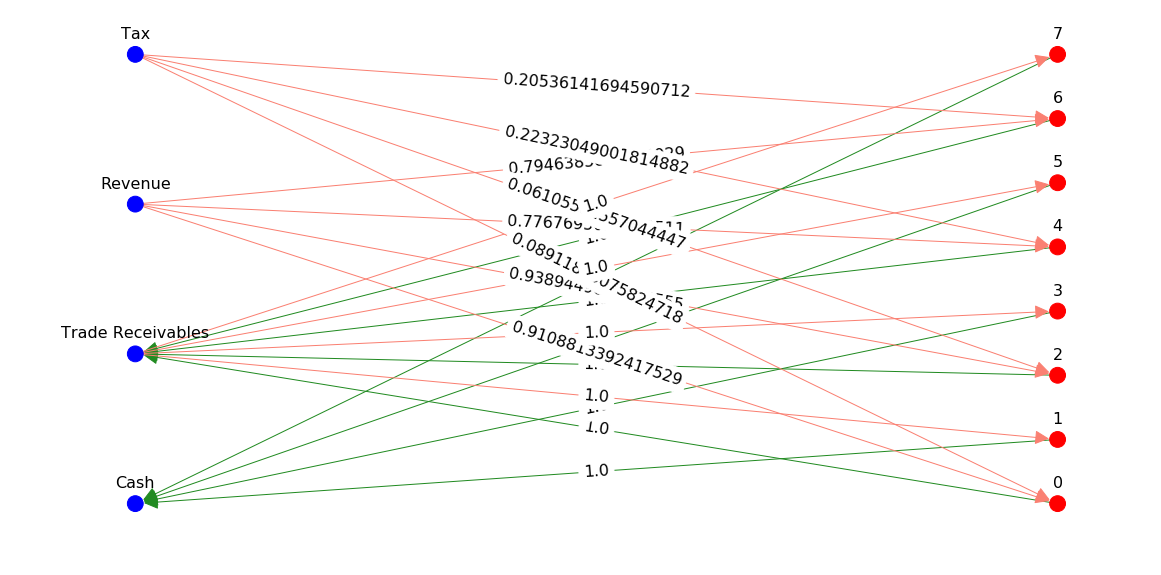

In [261]:
plot_network_v2(exp4)

### Default RandomWalk: without changing the direction, uniform transition probabiity. Does not work. At all.

In [164]:
def_randomWalk(exp4, 0, 10, direction="IN")

[0, -2]

{(0, 7): 4, (0, -2): 10, (7, 0): 4, (7, -2): 22, (-2, 0): 10, (-2, 7): 22, (1, -2): 25, (-2, 1): 25, (2, 1): 4, (2, -2): 10, (1, 2): 4, (-2, 2): 10, (3, -2): 15, (-2, 3): 15, (4, 7): 3, (4, -2): 10, (7, 4): 3, (-2, 4): 10, (5, -2): 18, (-2, 5): 18, (6, 3): 1, (6, -2): 10, (3, 6): 1, (-2, 6): 10, (0, 1): 4, (1, 0): 4, (2, 5): 2, (5, 2): 2, (4, 1): 3, (1, 4): 3, (6, 1): 4, (1, 6): 4, (0, 5): 2, (5, 0): 2, (2, 7): 2, (7, 2): 2, (6, 5): 2, (5, 6): 2, (4, 5): 2, (5, 4): 2, (2, 3): 2, (3, 2): 2, (4, 3): 2, (3, 4): 2, (6, 7): 3, (7, 6): 3}


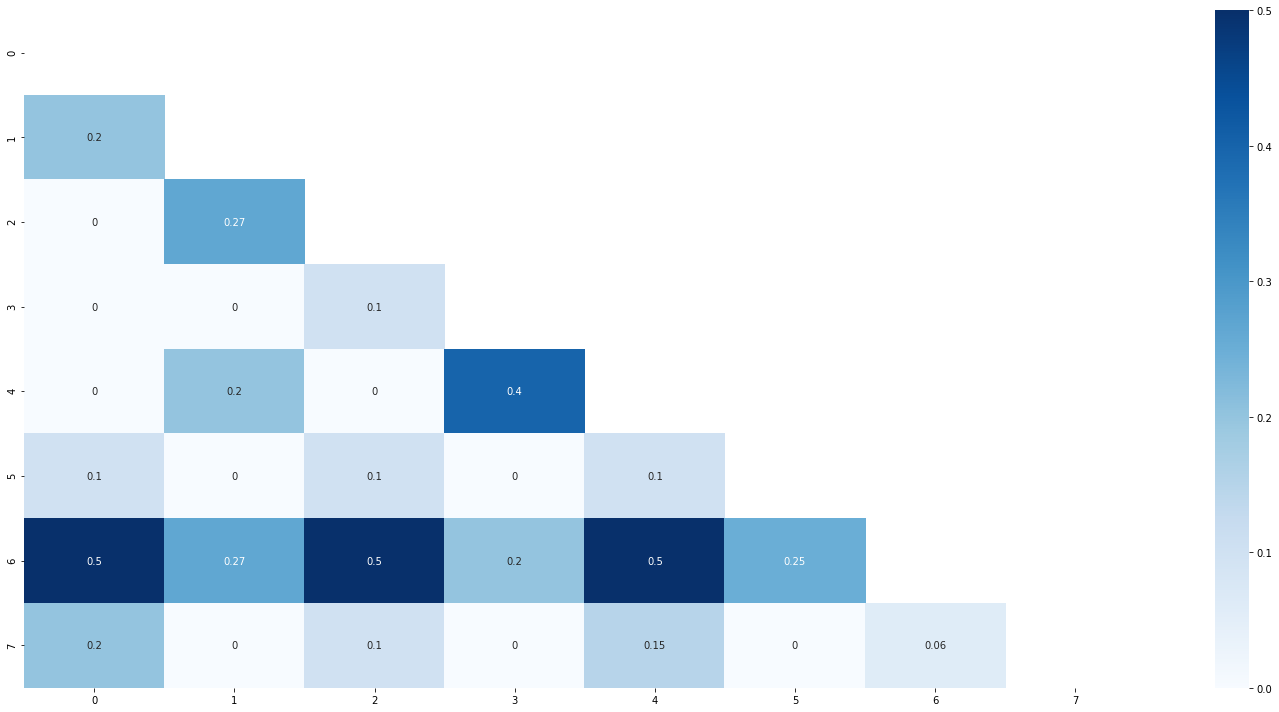

In [210]:
pairs = [make_pairs(def_randomWalk(exp4, node, 10, direction="OUT")) for _ in range(10) for node in range(8)]
pairs = [item for sublist in pairs for item in sublist]
plot_heatmap(pairs, norm="col", size=8, debug=True)

### Change direction (follow the logic of FSN) but uniform transition probability

{(0, 4): 134, (0, 2): 157, (0, 0): 84, (4, 0): 134, (4, 2): 158, (2, 0): 157, (2, 4): 158, (2, 2): 116, (2, 6): 164, (0, 6): 125, (6, 2): 164, (6, 0): 125, (6, 6): 98, (1, 7): 143, (1, 1): 88, (7, 1): 143, (7, 7): 98, (7, 3): 152, (1, 3): 137, (1, 5): 148, (7, 5): 160, (3, 7): 152, (3, 1): 137, (3, 5): 147, (5, 1): 148, (5, 7): 160, (5, 3): 147, (6, 4): 146, (4, 6): 146, (3, 3): 96, (4, 4): 94, (5, 5): 104}


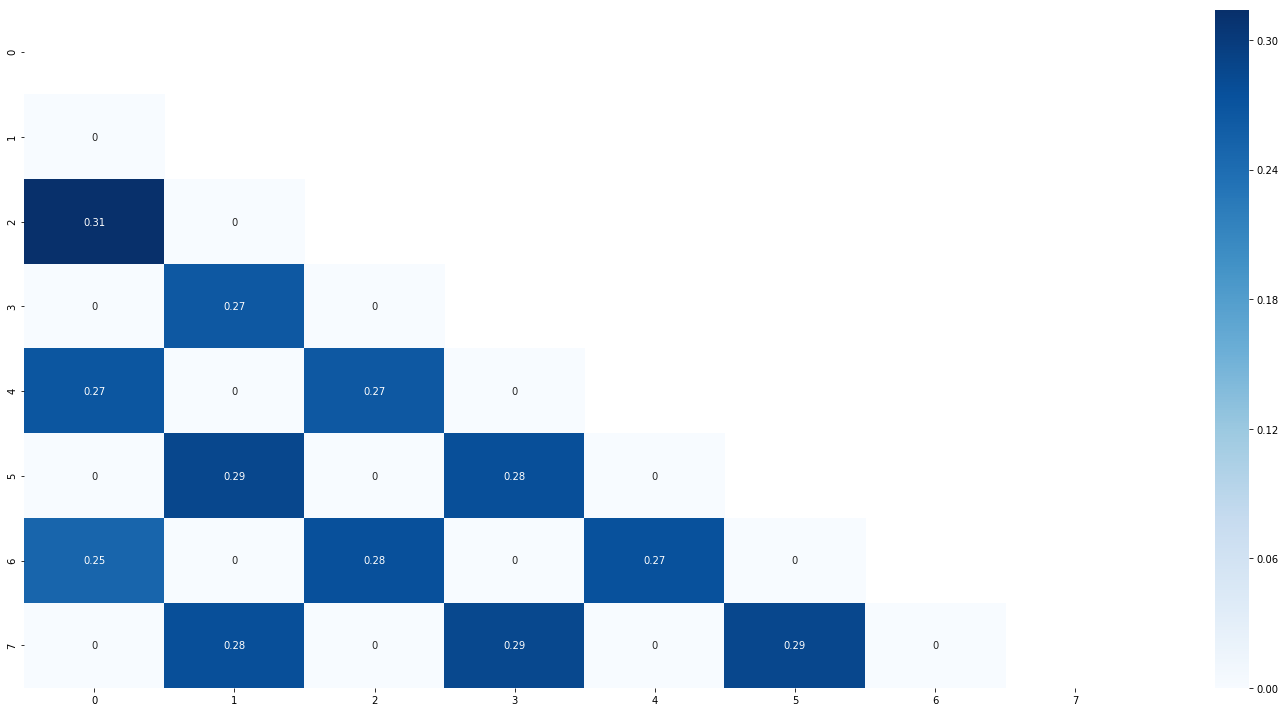

In [227]:
pairs = [make_pairs(new_randomWalk(exp4, node, 10, direction="OUT", repeat=False, pressure=11, mode=0)) for _ in range(10) for node in range(8)]
pairs = [item for sublist in pairs for item in sublist]
e2 = plot_heatmap(pairs, norm="col", size=8, return_hm=True, debug=True)

### Random walk without capturing similar amounts of monetary flow

{(0, 2): 179, (0, 4): 144, (2, 0): 179, (2, 4): 158, (2, 2): 132, (4, 0): 144, (4, 2): 158, (2, 6): 148, (0, 6): 120, (6, 2): 148, (6, 0): 120, (6, 4): 134, (4, 6): 134, (4, 4): 80, (1, 7): 159, (1, 1): 84, (7, 1): 159, (7, 7): 88, (7, 5): 161, (1, 5): 159, (1, 3): 151, (7, 3): 147, (5, 7): 161, (5, 1): 159, (5, 3): 131, (5, 5): 96, (3, 1): 151, (3, 7): 147, (3, 5): 131, (6, 6): 86, (0, 0): 96, (3, 3): 76}


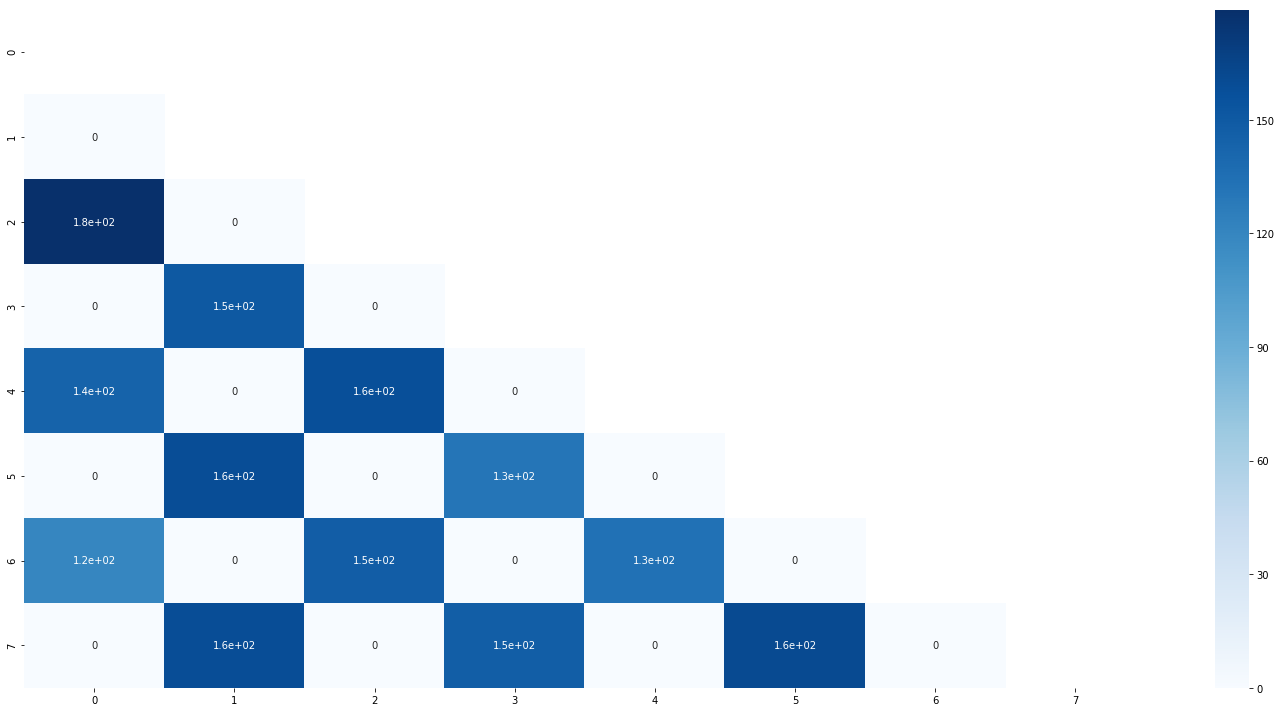

In [235]:
pairs = [make_pairs(new_randomWalk(exp4, node, 10, direction="IN", repeat=False, pressure=11, mode=1)) for _ in range(10) for node in range(8)]
pairs = [item for sublist in pairs for item in sublist]
plot_heatmap(pairs, norm="col", size=8, title="Pres_e2", absolute_vals=True, debug=True)

In [222]:
prs = np.array([0.91, 0.77, 0.79])
prs/np.sum(prs)

array([0.36842105, 0.31174089, 0.31983806])

### Modified Random Walk: encourage to choose next node with lowest difference in monetary flow

{(0, 6): 70, (0, 0): 96, (0, 2): 167, (6, 0): 70, (6, 2): 46, (0, 4): 50, (2, 0): 167, (2, 6): 46, (2, 4): 34, (4, 0): 50, (4, 2): 34, (1, 7): 105, (1, 3): 136, (1, 1): 72, (7, 1): 105, (7, 3): 110, (3, 1): 136, (3, 7): 110, (3, 3): 96, (3, 5): 131, (1, 5): 114, (5, 3): 131, (5, 1): 114, (5, 5): 58, (2, 2): 72, (6, 4): 260, (6, 6): 136, (4, 6): 260, (4, 4): 122, (5, 7): 99, (7, 5): 99, (7, 7): 64}


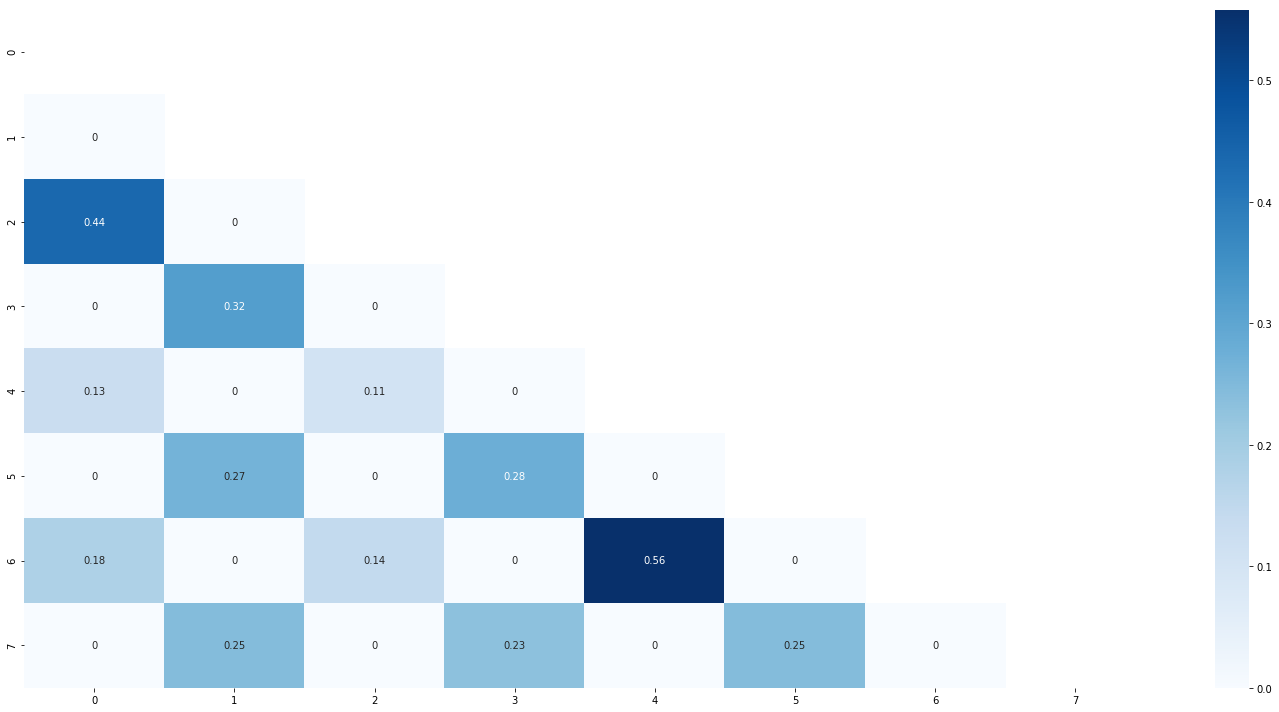

In [236]:
pairs = [make_pairs(new_randomWalk(exp4, node, 8, direction="IN", repeat=False, pressure=20, mode=2)) for _ in range(10) for node in range(8)] 
pairs = [item for sublist in pairs for item in sublist]
plot_heatmap(pairs, norm="col", size=8, title="Last_e", debug=True)

In [256]:
from networkx.algorithms import bipartite
def return_projection(G, on="BP"):
    if on=="BP":
        project_to = [n for n, d in G.nodes(data=True) if d['bipartite']==0]
    elif on=="FA":
        project_to = [n for n, d in G.nodes(data=True) if d['bipartite']==1]
    return bipartite.weighted_projected_graph(G, project_to)

In [258]:
proj = return_projection(exp4, on="BP")
proj.edges(data=True)

OutEdgeDataView([(0, 1, {'weight': 1}), (0, 3, {'weight': 1}), (0, 5, {'weight': 1}), (0, 7, {'weight': 1}), (2, 1, {'weight': 1}), (2, 3, {'weight': 1}), (2, 5, {'weight': 1}), (2, 7, {'weight': 1}), (4, 1, {'weight': 1}), (4, 3, {'weight': 1}), (4, 5, {'weight': 1}), (4, 7, {'weight': 1}), (6, 1, {'weight': 1}), (6, 3, {'weight': 1}), (6, 5, {'weight': 1}), (6, 7, {'weight': 1})])